# Parsing the retrospective Hodgkin-Lymphoma screening data

In [ ]:
import sys
sys.path.insert(0, '..')

### RIS file parsing

In [1]:
from pathlib import Path

PATH_PREFIX = "hodgkin_lymphoma_retro"
GUIDELINE_ID = "hodgkin-lymphom"

PATH_GGPONC_LITERATURE = Path("../data/screening/ggponc_v2.1_2023_03_30_literature.csv")
PATH_RIS = Path(f"../data/screening/{PATH_PREFIX}/")
PATH_OUTPUT = Path(f"../data/screening/{PATH_PREFIX}/ris_with_matched_ids.csv")

PATH_LATEX_PLOT_OUTPUT = Path(
    f"../thesis/from_python/figures/experiments/{PATH_PREFIX}/"
)
PATH_LATEX_PLOT_OUTPUT.mkdir(parents=True, exist_ok=True)

In [2]:
import pandas as pd
from evaluation.parsing import parse_kg_ris_file
import rispy

In [3]:
df_ris = (
    pd.concat(
        [parse_kg_ris_file(f, rispy.RisParser()) for f in PATH_RIS.rglob("*.txt")]
    )
    .rename(columns={"custom7": "pm_id", "custom2": "pmc_id"})
    .reset_index(drop=True)
)

In [4]:
from evaluation.parsing import parse_ris_date_to_datetime

df_ris["publication_date"] = parse_ris_date_to_datetime(
    df_ris, col_year="year", col_date="date"
)

In [5]:
df_ris["subgroup"] = df_ris["path"].apply(lambda p: p.stem)

In [6]:
df_ris["is_rct_ris"] = df_ris["subgroup"].str.strip() == "included_rcts"

In [7]:
df_ris["is_included"] = df_ris["subgroup"].apply(
    lambda g: g.strip() in ["included_rcts", "included_srs"]
)

In [8]:
df_ris["exclusion_reason"] = df_ris.apply(
    lambda row: str(row["subgroup"]) if not row["is_included"] else None, axis=1
)

In [9]:
import urllib

df_ris["url"] = df_ris["url"].apply(
    lambda s: urllib.parse.unquote(s, encoding="utf-8", errors="replace")
    if pd.notnull(s)
    else ""
)

### Extracting identifiers

In [10]:
from evaluation.parsing import REGEX

In [11]:
df_ris["nct_id"] = pd.NA
df_ris["cn_id"] = pd.NA
df_ris["doi_original"] = df_ris["doi"]
df_ris["doi"] = pd.NA

In [12]:
df_ris["pm_id"] = (
    df_ris["pm_id"]
    .fillna(df_ris["accession_number"].str.extract(REGEX["pm_id_start_end"])[0])
    .astype("Int64")
)

In [13]:
df_ris["pm_id"] = df_ris["pm_id"].fillna(
    df_ris["url"].str.extract(REGEX["pm_id_from_query"])[0]
)

In [14]:
df_ris["doi"] = df_ris["doi_original"].str.extract(REGEX["doi"])

In [15]:
df_ris["doi"] = df_ris["doi"].fillna(
    df_ris["url"].str.extract(REGEX["doi_from_query"])[0]
)

In [16]:
df_ris["cn_id"] = df_ris["url"].str.extract(REGEX["cn_id"])[0]

We should also rename the ID column to reflect that it comes from the RIS files:

In [17]:
df_ris.rename(columns={"id": "ris_id"}, inplace=True)

### Identifier lookups

In [18]:
from integration.config import load_config
from integration.db import get_engine
from sqlalchemy.orm import sessionmaker

cfg = load_config("../config_v2.1_2023_03_30.ini")
engine = get_engine(cfg['DB']['url'])
session = sessionmaker(bind=engine)()

In [19]:
from integration.citation_utils import (
    get_title_to_id_mapping_pubmed,
    get_title_to_id_mapping_clinicaltrials,
)

df_pm = get_title_to_id_mapping_pubmed(session)
df_ct = get_title_to_id_mapping_clinicaltrials(session)

In [20]:
from tqdm.auto import tqdm
from integration.citation_utils import retrieve_all_identifiers
import os

tqdm.pandas(desc="Retrieving available identifiers")

df_ris = df_ris.progress_apply(  # type: ignore
    lambda row: retrieve_all_identifiers(
        row=row,
        entrez_email=os.environ.get("PUBMED_USER"),
        entrez_api_key=os.environ.get("PUBMED_API_KEY"),
        doi_pm_id_cache="../data/literature/doi_to_pm_id.json",
        cn_pm_id_cache="../data/literature/cn_id_to_pm_id.json",
        title_nct_id_cache="../data/literature/fuzzy_title_to_nct_id.json",
        title_pm_id_cache="../data/literature/fuzzy_title_to_pm_id.json",
        df_pm=df_pm,
        df_ct=df_ct,
    ),
    axis=1,
)
df_ris = df_ris.astype(
    {col: "Int64" for col in df_ris.columns if "pm_id" in col.lower()}
)

Retrieving available identifiers:   0%|          | 0/47 [00:00<?, ?it/s]

Potential mislabellings:

In [21]:
df_ris[
    [
        "title",
        "ris_id",
        "pm_id",
        "nct_id",
        "doi",
        "cn_id",
        "pm_id_doi",
        "pm_id_cn",
        "nct_id_cn",
        "pmc_id_cn",
        "nct_id_db",
        "pm_id_db",
    ]
].query(
    "pm_id_db.notnull() & pm_id.notnull() & pm_id != pm_id_db"
)  # .merge(df_pm, left_on="pm_id", right_on="pm_id", suffixes=("_ris", "_db"))  # to get correct title

,title,ris_id,pm_id,nct_id,doi,cn_id,pm_id_doi,pm_id_cn,nct_id_cn,pmc_id_cn,nct_id_db,pm_id_db


### Check if evidence is in the database

In [22]:
from evaluation.matching import is_in_db
from tqdm.auto import tqdm

tqdm.pandas(desc="Checking of evidence is in database")

db_pm_ids = set(df_pm["pm_id"])
db_nct_ids = set(df_ct["nct_id"])

df_ris = df_ris.progress_apply(
    lambda row: is_in_db(row=row, db_pm_ids=db_pm_ids, db_nct_ids=db_nct_ids), axis=1
)

Checking of evidence is in database:   0%|          | 0/47 [00:00<?, ?it/s]

### Retrieving Publication Types & Date

In [23]:
from tqdm.auto import tqdm
import os
from integration.citation_utils import pm_id_to_publication_types

tqdm.pandas(desc="Fetching article types")

df_ris["publication_types"] = df_ris["pm_id"].progress_apply(
    lambda pm_id: pm_id_to_publication_types(
        pm_id=pm_id,
        email=os.environ.get("PUBMED_USER"),
        api_key=os.environ.get("PUBMED_API_KEY"),
        cache_path="../data/literature/pm_id_to_entrez_xml.json",
    )
)

Fetching article types:   0%|          | 0/47 [00:00<?, ?it/s]

In [24]:
from integration.citation_utils import set_rct_flag

df_ris = df_ris.apply(set_rct_flag, axis=1)

In [25]:
from integration.citation_utils import pm_id_to_publication_date

tqdm.pandas(desc="Fetching article dates")

df_ris["article_date_api"] = pd.to_datetime(
    df_ris["pm_id"].progress_apply(
        lambda pm_id: pm_id_to_publication_date(
            pm_id=pm_id,
            email=os.environ.get("PUBMED_USER"),
            api_key=os.environ.get("PUBMED_API_KEY"),
            cache_path="../data/literature/pm_id_to_entrez_xml.json",
        )
    )
)

Fetching article dates:   0%|          | 0/47 [00:00<?, ?it/s]

Couldn't find article date for 27007004
Couldn't find article date for 27332902
Couldn't find article date for 27650181
Couldn't find article date for 27316375
Couldn't find article date for 26482577


### Presence in GGPONC

In [26]:
from evaluation.matching import is_in_ggponc
from tqdm.auto import tqdm

df_ggponc = (
    pd.read_csv(PATH_GGPONC_LITERATURE)
    .astype({"pm_id": "Int64"})
    .query("guideline_id == @GUIDELINE_ID")
)
ggponc_pm_ids = set(df_ggponc["pm_id"].dropna())
ggponc_titles = set(df_ggponc["title"])

tqdm.pandas(desc="Checking for presence in GGPONC")
df_ris = df_ris.progress_apply(
    lambda row: is_in_ggponc(
        row=row, ggponc_pm_ids=ggponc_pm_ids, ggponc_titles=ggponc_titles
    ),
    axis=1,
)

Checking for presence in GGPONC:   0%|          | 0/47 [00:00<?, ?it/s]

### Preparing final dataframe

For the final analyses, we need to deduplicate the data:

In [27]:
df_ris.sort_values(
    ["title", "pm_id", "nct_id", "cn_id", "doi", "is_included"], inplace=True
)

In [28]:
df_ris.drop_duplicates(
    ["title", "pm_id", "nct_id", "cn_id", "doi"], keep="last", inplace=True
)

In [29]:
n_non_null_pm_id_duplicates = len(
    df_ris[
        df_ris["pm_id"].duplicated(keep=False) & df_ris["pm_id"].notnull()
    ].sort_values(["pm_id", "is_included"], ascending=False)
)

print(
    f"There are {n_non_null_pm_id_duplicates} non-null PM ID duplicates in the dataset!"
)

There are 0 non-null PM ID duplicates in the dataset!


In [30]:
pd.crosstab(df_ris["is_included"], df_ris["is_rct_api"], margins=True)

is_rct_api,False,True,All
is_included,,,
False,26,3,29
True,9,8,17
All,35,11,46


In [31]:
df_ris.query("is_included & is_rct_api & pm_id.isnull()")

,type_of_reference,authors,pm_id,name_of_database,database_provider,number,alternate_title1,keywords,language,type_of_work,...,nct_id_db,pm_id_db,is_in_db_pm,is_in_db_ct,is_in_db_title,is_in_db,publication_types,is_rct_api,article_date_api,is_in_ggponc


We mark every record that has been identified as being in or relevant to a previous version of the CPG as being in GGPONC:

In [32]:
df_ris["is_in_ggponc"] = df_ris["is_in_ggponc"] | (
    df_ris["subgroup"] == "previous_version_of_ll"
)

We then consider every included record or every one that has been marked as being in GGPONC as relevant:

In [33]:
df_ris["is_relevant"] = df_ris["is_included"] | df_ris["is_in_ggponc"]
df_ris["is_not_relevant"] = ~df_ris["is_relevant"]

Finally, for compatibility with the other data sets, we set the screening origin to 'original':

In [34]:
df_ris["screening_origin"] = "original"

### Saving the output

In [35]:
from evaluation.parsing import save_parsed_ris_content

In [36]:
save_parsed_ris_content(
    df=df_ris,
    guideline_id="hodgkin-lymphom",
    guideline_name="Hodgkin's Lymphoma",
    csv_path=PATH_OUTPUT,
    cols_additional=["is_rct_ris"],
)

#### Sankey Diagram for thesis

In [37]:
relevant = df_ris.query("is_relevant")
relevant_in_ggponc = relevant.query("is_in_ggponc")
relevant_in_ggponc_rcts_api = relevant_in_ggponc.query("is_rct_api")
relevant_in_ggponc_other_api = relevant_in_ggponc.query("~is_rct_api")
relevant_not_in_ggponc = relevant.query("~is_in_ggponc")
relevant_not_in_ggponc_rcts_api = relevant_not_in_ggponc.query("is_rct_api")
relevant_not_in_ggponc_other_api = relevant_not_in_ggponc.query("~is_rct_api")

relevant_rcts = relevant.query("is_rct_api")
relevant_other = relevant.query("~is_rct_api")

inc = df_ris.query("is_included")
inc_ggponc = inc.query("is_in_ggponc")
inc_not_in_ggponc = inc.query("~is_in_ggponc")
inc_not_in_ggponc_rcts_api = inc_not_in_ggponc.query("is_rct_api")
inc_not_in_ggponc_other_api = inc_not_in_ggponc.query("~is_rct_api")

exc_abstract = df_ris.query("subgroup == 'excluded_abstract'")
exc_abstract_in_ggponc = exc_abstract.query("is_in_ggponc")
exc_abstract_not_in_ggponc = exc_abstract.query("~is_in_ggponc")

exc_trial_registries = df_ris.query("subgroup == 'excluded_trial_registries'")
exc_trial_registries_in_ggponc = exc_trial_registries.query("is_in_ggponc")
exc_trial_registries_not_in_ggponc = exc_trial_registries.query("~is_in_ggponc")

prev = df_ris.query("subgroup == 'previous_version_of_ll'")
prev_in_ggponc = prev.query("is_in_ggponc")
prev_not_in_ggponc = prev.query("~is_in_ggponc")
prev_not_in_ggponc_rcts_api = prev_not_in_ggponc.query("is_rct_api")
prev_not_in_ggponc_other_api = prev_not_in_ggponc.query("~is_rct_api")

in_ggponc = df_ris.query("is_in_ggponc")
in_ggponc_rcts_api = in_ggponc.query("is_rct_api")
in_ggponc_other_api = in_ggponc.query("~is_rct_api")

In [38]:
nodes = [
    [("Screened", len(df_ris))],
    [
        ("Excluded (Abstract)", len(exc_abstract), {"label_pos": "right"}),
        (
            "Excluded (Trial Registries)",
            len(exc_trial_registries),
            {"label_pos": "right"},
        ),
        ("Previous\nCPG Version", len(prev), {"label_pos": "bottom"}),
        ("Included", len(inc), {"label_pos": "bottom"}),
    ],
    [
        ("Already cited\nin CPG", len(relevant_in_ggponc), {"label_pos": "top"}),
        ("Not\nin CPG", len(relevant_not_in_ggponc), {"label_pos": "bottom"}),
    ],
    [
        ("RCTs", len(relevant_rcts), {"label_pos": "right"}),
        ("Other", len(relevant_other), {"label_pos": "right"}),
    ],
]

In [39]:
flows = [
    ("Screened", "Excluded (Abstract)", len(exc_abstract)),
    ("Screened", "Excluded (Trial Registries)", len(exc_trial_registries)),
    ("Screened", "Previous\nCPG Version", len(prev)),
    ("Screened", "Included", len(inc)),
    ("Excluded (Abstract)", "Already cited\nin CPG", len(exc_abstract_in_ggponc)),
    (
        "Excluded (Trial Registries)",
        "Already cited\nin CPG",
        len(exc_trial_registries_in_ggponc),
    ),
    ("Previous\nCPG Version", "Already cited\nin CPG", len(prev_in_ggponc)),
    ("Previous\nCPG Version", "Not\nin CPG", len(prev_not_in_ggponc)),
    ("Included", "Already cited\nin CPG", len(inc_ggponc)),
    ("Included", "Not\nin CPG", len(inc_not_in_ggponc)),
    ("Already cited\nin CPG", "RCTs", len(relevant_in_ggponc_rcts_api)),
    ("Already cited\nin CPG", "Other", len(relevant_in_ggponc_other_api)),
    (
        "Not\nin CPG",
        "RCTs",
        len(inc_not_in_ggponc_rcts_api) + len(prev_not_in_ggponc_rcts_api),
    ),
    (
        "Not\nin CPG",
        "Other",
        len(inc_not_in_ggponc_other_api) + len(prev_not_in_ggponc_other_api),
    ),
]

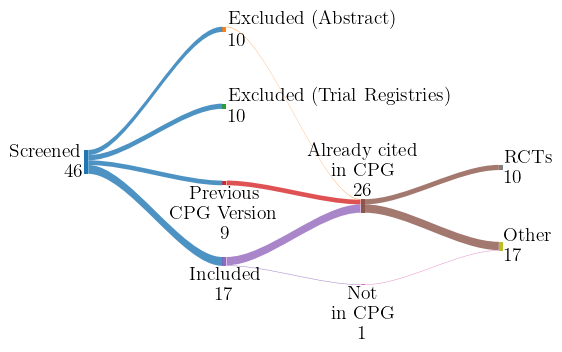

In [40]:
from sankeyflow import Sankey
from evaluation.plotting import set_size
import matplotlib.pyplot as plt

plt.style.use("../thesis.mplstyle")

fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")

s = Sankey(
    flow_color_mode="source",
    nodes=nodes,
    flows=flows,
    node_pad_y_min=0.3,
    align_y="tree",
    flow_color_mode_alpha=0.8,
)
s.draw(ax=ax)

fig.savefig(PATH_LATEX_PLOT_OUTPUT / "sankey_unique_per_step_reconstructed.pdf")